# ***Text Classification  [E-commerce Dataset](https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification) from [Kaggle website](https://www.kaggle.com/).***

***

**Authors:**
- Jean-Baptiste GOMEZ
- Ulrich SEGODO

**Overview:**

The primary goal of this project is to categorize e-commerce products into four distinct groups: `Electronics`, `Household`, `Books`, and `Clothing & Accessories`, based on their descriptions available on various e-commerce platforms. The key steps undertaken in this notebook include:

1. Conducted basic **Exploratory Data Analysis**, comparing the distributions of character count, word count, and average word length in product descriptions across different categories.

2. Applied various **text normalization techniques** to enhance the consistency of product descriptions.

3. Utilized **TF-IDF vectorization** on the normalized product descriptions for effective text representation. The baseline performance of several classifiers was compared, and hyperparameter tuning was executed specifically on **SVM Classifier**.

4. Explored an alternative approach by implementing selected text normalization processes, such as converting to lowercase and substituting contractions directly on the raw data of product descriptions. Employed Google's pre-trained **Word2Vec model** on tokens derived from partially normalized descriptions, generating embeddings subsequently converted to compressed sparse row (CSR) format. Baseline performance of various classifiers was assessed, and hyperparameter tuning was conducted on the **XGBoost classifier**.

5. Applied the model with the highest validation accuracy to predict labels for test observations, achieving a notable test accuracy of **0.950378**.

6. Utilized the **Google [BERT](https://github.com/google-research/bert)(Bidirectional Encoder Representations from Transformers)** model through the **Hugging Face Transformers library** in our project. Following the modeling phase and fine-tuning of the model, we achieved an impressive test accuracy, specifically **0.957569.**

**About Dataset**

This is the classification based E-commerce text dataset for **4 categories** - `Electronics`, `Household`, `Books` and `Clothing & Accessories`, which almost cover **80%** of any E-commerce website.

The dataset is in `.csv` format with two columns - the first column is the class name and the second one is the datapoint of that class. The data point is the product and description from the e-commerce website.

The dataset has the following features :

**Data Set Characteristics:** Multivariate

**Number of Instances:** 50425

**Number of classes:** 4

**Area:** Computer science

**Attribute Characteristics:** Real

**Number of Attributes:** 1

**Associated Tasks:** Classification

**Missing Values?** No

Gautam. (2019). E commerce text dataset (version - 2) [Data set]. [Zenodo](https://doi.org/10.5281/zenodo.3355823).

# Importing Library

In [1]:
#! pip install num2words
#! pip install pyspellchecker
#! python -m pip install spacy 

In [2]:
# File system manangement
import time, psutil, os

# Data manipulation
import numpy as np
#%pip install pandas
import pandas as pd

# Plotting and visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#%pip install seaborn
import seaborn as sns
sns.set_theme()
#%pip install plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# NLP
#%pip install nltk
import string, re, nltk
nltk.download('averaged_perceptron_tagger')
from string import punctuation
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords

#%pip install num2words
from num2words import num2words
# %pip install indexer
#%pip install pyspellchecker
from spellchecker import SpellChecker
from nltk.stem.porter import PorterStemmer

#%pip install spacy
import spacy
from nltk.stem import WordNetLemmatizer

# TF-IDF
#%pip install -U scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

# Scipy
import scipy
from scipy import sparse
from scipy.sparse import csr_matrix
# Train-test split and cross validation
from sklearn.model_selection import train_test_split, ParameterGrid

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
#%pip install xgboost
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

# Model evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score

#Transformer
#%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
#%pip install pytorch
import transformers
from transformers import AutoTokenizer,TFBertModel
import torch
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

# Others
import json
#%pip install gensim
import gensim
from sklearn.decomposition import TruncatedSVD


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\gomez\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
c:\Users\gomez\anaconda3\envs\tf-new\lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



# Data

In [3]:
# Loading and customizing the data
data = pd.read_csv("ecommerceDataset.csv",
    names = ['label', 'description']
)
data = data[['description', 'label']]

data

,description,label
0,Paper Plane Design Framed Wall Hanging Motivat...,Household
1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",Household
2,SAF 'UV Textured Modern Art Print Framed' Pain...,Household
3,"SAF Flower Print Framed Painting (Synthetic, 1...",Household
4,Incredible Gifts India Wooden Happy Birthday U...,Household
...,...,...
50420,Strontium MicroSD Class 10 8GB Memory Card (Bl...,Electronics
50421,CrossBeats Wave Waterproof Bluetooth Wireless ...,Electronics
50422,Karbonn Titanium Wind W4 (White) Karbonn Titan...,Electronics
50423,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou...",Electronics


In [4]:
# Example description
data['description'].iloc[0]

'Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour and style to your living space with this digitally printed painting. Some are for pleasure and some for eternal blis

In [5]:
# Missing values and duplicate observations
print(pd.Series({"Number of observations with missing values": len(data) - len(data.dropna()),
                 "Number of duplicate observations": data.duplicated().sum()}).to_string())

Number of observations with missing values        1
Number of duplicate observations              22622


In [6]:
data.dropna(inplace = True) # Dropping observations with missing values
data.drop_duplicates(inplace = True) # Dropping duplicate observations
data.reset_index(drop = True, inplace = True) # Resetting index

In [7]:
# Manual encoding of labels
label_dict = {'Electronics': 0, 'Household': 1, 'Books': 2, 'Clothing & Accessories': 3}
data.replace({'label': label_dict}, inplace = True)

print(pd.Series({"Dataset shape": "{}".format(data.shape)}).to_string())
data

Dataset shape    (27802, 2)


,description,label
0,Paper Plane Design Framed Wall Hanging Motivat...,1
1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",1
2,SAF 'UV Textured Modern Art Print Framed' Pain...,1
3,"SAF Flower Print Framed Painting (Synthetic, 1...",1
4,Incredible Gifts India Wooden Happy Birthday U...,1
...,...,...
27797,Micromax Bharat 5 Plus Zero impact on visual d...,0
27798,Microsoft Lumia 550 8GB 4G Black Microsoft lum...,0
27799,"Microsoft Lumia 535 (Black, 8GB) Colour:Black ...",0
27800,Karbonn Titanium Wind W4 (White) Karbonn Titan...,0


# Exploratory Data Analysis

We split the dataset based on the target classes, in order to see how different textual attributes vary across classes.

In [8]:
# Splitting the dataset by label
data_e = data[data['label'] == 0] # Electronics
data_h = data[data['label'] == 1] # Household
data_b = data[data['label'] == 2] # Books
data_c = data[data['label'] == 3] # Clothing & Accessories

## Class Frequencies

In [9]:
# Visualization of class frequencies
values = np.array([len(data_e), len(data_h), len(data_b), len(data_c)])
labels = ['Electronics', 'Household', 'Books', 'Clothing & Accessories']
fig = go.Figure(data = [go.Pie(values = values, labels = labels, hole = 0.5, textinfo = 'percent', title = " ")])
text_title = "Comparison of class frequencies"
fig.update_layout(height = 500, width = 800, showlegend = True, title = dict(text = text_title, x = 0.5, y = 0.95))
fig.show()

## Number of Characters

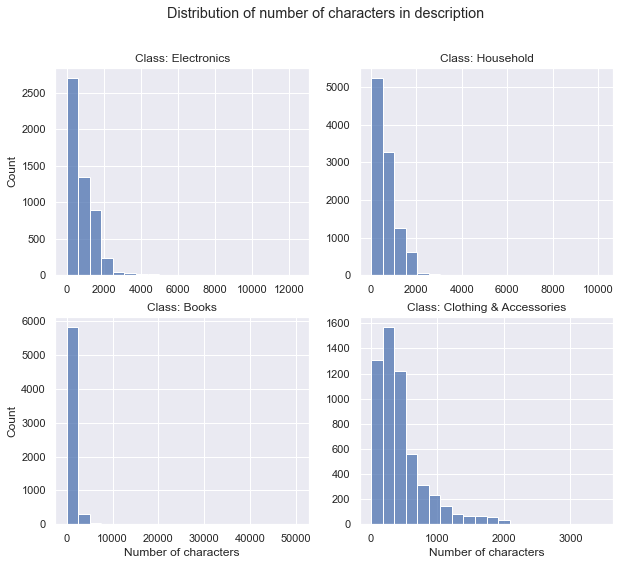

In [10]:
# Distribution of number of characters in description
data_e_char = data_e['description'].str.len()
data_h_char = data_h['description'].str.len()
data_b_char = data_b['description'].str.len()
data_c_char = data_c['description'].str.len()

fig, ax = plt.subplots(2, 2, figsize = (10, 8.4), sharey = False)
sns.histplot(x = data_e_char, bins = 20, ax = ax[0, 0]).set_title('Class: Electronics')
sns.histplot(x = data_h_char, bins = 20, ax = ax[0, 1]).set_title('Class: Household')
sns.histplot(x = data_b_char, bins = 20, ax = ax[1, 0]).set_title('Class: Books')
sns.histplot(x = data_c_char, bins = 20, ax = ax[1, 1]).set_title('Class: Clothing & Accessories')

fig.suptitle("Distribution of number of characters in description")
for i in range(4):
    ax[i // 2, i % 2].set_xlabel(" ") if i // 2 == 0 else ax[i // 2, i % 2].set_xlabel("Number of characters")
    if i % 2 != 0: ax[i // 2, i % 2].set_ylabel(" ")

## Number of Words

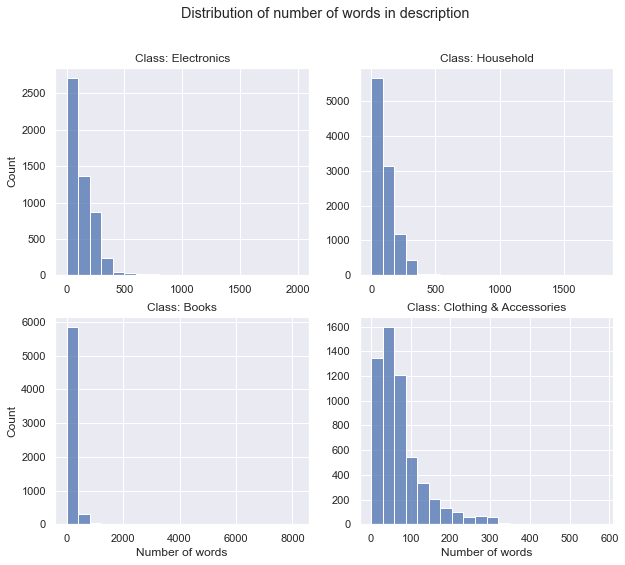

In [11]:
# Distribution of number of words in description
data_e_word = data_e['description'].str.split().map(lambda x: len(x))
data_h_word = data_h['description'].str.split().map(lambda x: len(x))
data_b_word = data_b['description'].str.split().map(lambda x: len(x))
data_c_word = data_c['description'].str.split().map(lambda x: len(x))

fig, ax = plt.subplots(2, 2, figsize = (10, 8.4), sharey = False)
sns.histplot(x = data_e_word, bins = 20, ax = ax[0, 0]).set_title('Class: Electronics')
sns.histplot(x = data_h_word, bins = 20, ax = ax[0, 1]).set_title('Class: Household')
sns.histplot(x = data_b_word, bins = 20, ax = ax[1, 0]).set_title('Class: Books')
sns.histplot(x = data_c_word, bins = 20, ax = ax[1, 1]).set_title('Class: Clothing & Accessories')
fig.suptitle("Distribution of number of words in description")
for i in range(4):
    ax[i // 2, i % 2].set_xlabel(" ") if i // 2 == 0 else ax[i // 2, i % 2].set_xlabel("Number of words")
    if i % 2 != 0: ax[i // 2, i % 2].set_ylabel(" ")

In [12]:
data_e['description']

22494    Dell 19.5V-3.34AMP 65W Laptop Adapter (Without...
22495    Bluetooth Dongle USB CSR 4.0 Adapter Receiver ...
22496    Wi-Fi Receiver 300Mbps, 2.4GHz, 802.11b/g/n US...
22497    SanDisk 64GB Class 10 microSDXC Memory Card wi...
22498    Gizga Essentials Laptop Power Cable Cord- 3 Pi...
                               ...                        
27797    Micromax Bharat 5 Plus Zero impact on visual d...
27798    Microsoft Lumia 550 8GB 4G Black Microsoft lum...
27799    Microsoft Lumia 535 (Black, 8GB) Colour:Black ...
27800    Karbonn Titanium Wind W4 (White) Karbonn Titan...
27801    Nokia Lumia 530 (Dual SIM, Grey) Colour:Grey  ...
Name: description, Length: 5308, dtype: object

## Train-Validation-Test Split

In [13]:
# Feature-target split
X, y = data.drop('label', axis = 1), data['label']

# Train-test split (from complete data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)
data_train = pd.concat([X_train, y_train], axis = 1)

# Validation-test split (from test data)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 40)
data_val, data_test = pd.concat([X_val, y_val], axis = 1), pd.concat([X_test, y_test], axis = 1)

# Comparison of sizes of training set, validation set and test set
values = np.array([len(data_train), len(data_val), len(data_test)])
labels = ['Training set', 'Validation Set', 'Test set']
fig = go.Figure(data = [go.Pie(values = values, labels = labels, hole = 0.5, textinfo = 'percent', title = " ")])
text_title = "Comparison of sizes of training set, validation set and test set"
fig.update_layout(height = 500, width = 800, showlegend = True, title = dict(text = text_title, x = 0.5, y = 0.95))
fig.show()

## Text Normalization

In natural language processing, text normalization is the process of transforming text into a single canonical form. We consider a number of text normalization processes. At the end of the section, we combine selected processes into one single function and apply it on the product descriptions.

In [14]:
# RegexpTokenizer
regexp = RegexpTokenizer("[\w']+")

# Converting to lowercase
def convert_to_lowercase(text):
    return text.lower()

# Removing whitespaces
def remove_whitespace(text):
    return text.strip()

# Removing punctuations
def remove_punctuation(text):
    punct_str = string.punctuation
    punct_str = punct_str.replace("'", "") # discarding apostrophe from the string to keep the contractions intact
    return text.translate(str.maketrans("", "", punct_str))

# Removing HTML tags
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

# Removing emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags = re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Removing other unicode characters
def remove_http(text):
    http = "https?://\S+|www\.\S+" # matching strings beginning with http (but not just "http")
    pattern = r"({})".format(http) # creating pattern
    return re.sub(pattern, "", text)



### Substitution of Acronyms

Acronyms are shortened forms of phrases, generally found in informal writings. For instance, for your information is written as fyi and by the way is written as btw. These time and effort-saving acronyms have received almost universal acceptance in recent times. For the sake of proper modeling, we convert the acronyms, appearing in the tweets, back to their respective original forms.

In [15]:
# Dictionary of acronyms
acronyms_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_acronyms.json'
acronyms_dict = pd.read_json(acronyms_url, typ = 'series')
# Dataframe of acronyms
pd.DataFrame(acronyms_dict.items(), columns = ['acronym', 'original']).head()

,acronym,original
0,aka,also known as
1,asap,as soon as possible
2,brb,be right back
3,btw,by the way
4,dob,date of birth


In [16]:
# List of acronyms
acronyms_list = list(acronyms_dict.keys())

# Function to convert acronyms in a text
def convert_acronyms(text):
    words = []
    for word in regexp.tokenize(text):
        if word in acronyms_list:
            words = words + acronyms_dict[word].split()
        else:
            words = words + word.split()

    text_converted = " ".join(words)
    return text_converted

text = "btw you've to fill in the details including dob"
print("Input: {}".format(text))
print("Output: {}".format(convert_acronyms(text)))

Input: btw you've to fill in the details including dob
Output: by the way you've to fill in the details including date of birth


###  Substitution of Contractions
A contraction is a shortened form of a word or a phrase, obtained by dropping one or more letters.

These are commonly used in everyday speech, written dialogue, informal writing and in situations where space is limited or costly, such as advertisements. Usually the missing letters are indicated by an apostrophe, but there are exceptions. Examples: I'm = I am, let's = let us, won't = would not, howdy = how do you do.

We have compiled an extensive list of English contractions, which can be found in the attached .json file titled english_contractions. The list is largely based on information obtained from this wikipedia page on list of English contractions. Note that the file only considers contractions in lowercase, i.e. it assumes that the textual data have already been transformed to lowercase before substituting the contractions. For example, the process will convert i'll to i shall but will leave I'll unchanged.

In [17]:
# Dictionary of contractions
contractions_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_contractions.json'
contractions_dict = pd.read_json(contractions_url, typ = 'series')
# Dataframe of contractions
pd.DataFrame(contractions_dict.items(), columns = ['contraction', 'original']).head()

,contraction,original
0,'aight,alright
1,ain't,are not
2,amn't,am not
3,arencha,are not you
4,aren't,are not


The contractions do not always have a one-to-one mapping with the original words. For example i'd can come from both i had and i would. In the .json file only one the original words/phrases are chosen. However, this does not affect our analysis since words like had and would, which do not have any meaningful contribution in achieving the objective of the project, will be discarded in the next subsection

In [18]:
# List of contractions
contractions_list = list(contractions_dict.keys())

# Function to convert contractions in a text
def convert_contractions(text):
    words = []
    for word in regexp.tokenize(text):
        if word in contractions_list:
            words = words + contractions_dict[word].split()
        else:
            words = words + word.split()

    text_converted = " ".join(words)
    return text_converted

text = "he's doin' fine"
print("Input: {}".format(text))
print("Output: {}".format(convert_contractions(text)))

Input: he's doin' fine
Output: he is doing fine


### Removal of Stop Words
Several words, primarily pronouns, prepositions, modal verbs etc, are identified not to have much effect on the classification procedure. These are called stop words. To get rid of the unwanted contamination effect, we remove these words.

In [19]:
# Stopwords
nltk.download('stopwords')

stops = stopwords.words("english") # stopwords
addstops = ["among", "onto", "shall", "thrice", "thus", "twice", "unto", "us", "would"] # additional stopwords
allstops = stops + addstops

print(allstops)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gomez\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
# Function to remove stopwords from a list of texts
def remove_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in allstops])

text = "This is a function that removes stopwords in a given text"
print("Input: {}".format(text))
print("Output: {}".format(remove_stopwords(text)))

Input: This is a function that removes stopwords in a given text
Output: This function removes stopwords given text


### Spelling Correction
The classification procedure cannot take mispellings into consideration and treats a word and its misspelt version as separate words. For this reason it is necessary to conduct spelling correction before feeding the data to the classification procedure.


In [21]:
# pyspellchecker
spell = SpellChecker()

def pyspellchecker(text):
    word_list = regexp.tokenize(text)
    word_list_corrected = []
    for word in word_list:
        if word in spell.unknown(word_list):
            word_corrected = spell.correction(word)
            if word_corrected == None:
                word_list_corrected.append(word)
            else:
                word_list_corrected.append(word_corrected)
        else:
            word_list_corrected.append(word)
    text_corrected = " ".join(word_list_corrected)
    return text_corrected

text = "I'm goinng therre"
print("Input: {}".format(text))
print("Output: {}".format(pyspellchecker(text)))

Input: I'm goinng therre
Output: I'm going there


### Stemming and Lemmatization
Stemming is the process of reducing the words to their root form or stem. It reduces related words to the same stem even if the stem is not a dictionary word. For example, the words introducing, introduced, introduction reduce to a common word introduce. However, the process often produces stems that are not actual words.

In [22]:
# Stemming
stemmer = PorterStemmer()
def text_stemmer(text):
    text_stem = " ".join([stemmer.stem(word) for word in regexp.tokenize(text)])
    return text_stem

text = "Introducing lemmatization as an improvement over stemming"
print("Input: {}".format(text))
print("Output: {}".format(text_stemmer(text)))

Input: Introducing lemmatization as an improvement over stemming
Output: introduc lemmat as an improv over stem


The stems introduc, lemmat and improv are not actual words. Lemmatization offers a more sophisticated approach by utilizing a corpus to match root forms of the words. Unlike stemming, it uses the context in which a word is being used.

In [23]:
# Lemmatization
import spacy

# Download spaCy model
spacy.cli.download("en_core_web_sm")

spacy_lemmatizer = spacy.load("en_core_web_sm", disable = ['parser', 'ner'])
#lemmatizer = WordNetLemmatizer()

def text_lemmatizer(text):
    text_spacy = " ".join([token.lemma_ for token in spacy_lemmatizer(text)])
    #text_wordnet = " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(text)]) # regexp.tokenize(text)
    return text_spacy
    #return text_wordnet

text = "Introducing lemmatization as an improvement over stemming"
print("Input: {}".format(text))
print("Output: {}".format(text_lemmatizer(text)))

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Input: Introducing lemmatization as an improvement over stemming
Output: introduce lemmatization as an improvement over stem


### Discardment of Non-alphabetic Words
The non-alphabetic words are not numerous and create unnecessary diversions in the context of classifying tweets into non-disaster and disaster categories. Hence we discard these words.

In [24]:
# Discardment of non-alphabetic words
def discard_non_alpha(text):
    word_list_non_alpha = [word for word in regexp.tokenize(text) if word.isalpha()]
    text_non_alpha = " ".join(word_list_non_alpha)
    return text_non_alpha

text = "It is an ocean of thousands and 1000s of crowd"
print("Input: {}".format(text))
print("Output: {}".format(discard_non_alpha(text)))

Input: It is an ocean of thousands and 1000s of crowd
Output: It is an ocean of thousands and of crowd


### Retainment of Relevant Parts of Speech
The parts of speech provide a great tool to select a subset of words that are more likely to contribute in the classification procedure and discard the rest to avoid noise. The idea is to select a number of parts of speech that are important to the context of the problem. Then we partition the words in a given text into several subsets corresponding to each part of speech and keep only those subsets corresponding to the selected parts of speech.

In [25]:
def keep_pos(text):
    tokens = regexp.tokenize(text)
    tokens_tagged = nltk.pos_tag(tokens)
    keep_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'FW', 'PRP', 'PRPS', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WPS', 'WRB']
    keep_words = [x[0] for x in tokens_tagged if x[1] in keep_tags]
    return " ".join(keep_words)

text = "He arrived at seven o'clock on Wednesday evening"
print("Input: {}".format(text))
tokens = regexp.tokenize(text)
print("Tokens: {}".format(tokens))
tokens_tagged = nltk.pos_tag(tokens)
print("Tagged Tokens: {}".format(tokens_tagged))
print("Output: {}".format(keep_pos(text)))

Input: He arrived at seven o'clock on Wednesday evening
Tokens: ['He', 'arrived', 'at', 'seven', "o'clock", 'on', 'Wednesday', 'evening']
Tagged Tokens: [('He', 'PRP'), ('arrived', 'VBD'), ('at', 'IN'), ('seven', 'CD'), ("o'clock", 'NN'), ('on', 'IN'), ('Wednesday', 'NNP'), ('evening', 'NN')]
Output: He arrived o'clock Wednesday evening


### Removal of Additional Stop Words
Analyzing the data, we observe that several unnecessary words, which are not included in the ready-made set of stop words, keep appearing in the text corpus. We discard these words to remove noise in the classification procedure.

In [26]:
# Additional stopwords

alphabets = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m",
              "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
prepositions = ["about", "above", "across", "after", "against", "among", "around",
                 "at", "before", "behind", "below", "beside", "between", "by", "down",
                 "during", "for", "from", "in", "inside", "into", "near", "of", "off",
                 "on", "out", "over", "through", "to", "toward", "under", "up", "with"]
prepositions_less_common = ["aboard", "along", "amid", "as", "beneath", "beyond", "but",
                            "concerning", "considering", "despite", "except", "following",
                            "like", "minus", "onto", "outside", "per", "plus", "regarding",
                            "round", "since", "than", "till", "underneath", "unlike", "until",
                            "upon", "versus", "via", "within", "without"]
coordinating_conjunctions = ["and", "but", "for", "nor", "or", "so", "and", "yet"]
correlative_conjunctions = ["both", "and", "either", "or", "neither", "nor", "not",
                             "only", "but", "whether", "or"]
subordinating_conjunctions = ["after", "although", "as", "as if", "as long as", "as much as",
                               "as soon as", "as though", "because", "before", "by the time",
                                 "even if", "even though", "if", "in order that", "in case",
                                 "in the event that", "lest", "now that", "once", "only",
                                 "only if", "provided that", "since", "so", "supposing",
                                 "that", "than", "though", "till", "unless", "until", "when",
                                   "whenever", "where", "whereas", "wherever", "whether or not", "while"]

others = ["ã", "å", "ì", "û", "ûªm", "ûó", "ûò", "ìñ", "ûªre", "ûªve", "ûª", "ûªs", "ûówe"]
additional_stops = alphabets + prepositions + prepositions_less_common + coordinating_conjunctions + correlative_conjunctions + subordinating_conjunctions + others

def remove_additional_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in additional_stops])

### Integration of the Processes
We integrate the text normalization processes in appropriate order. We have kept the spelling correction step commented out as it takes a massive amount of time to run on large datasets.

In [27]:
def text_normalizer(text):
    text = convert_to_lowercase(text)
    text = remove_whitespace(text)
    text = re.sub('\n' , '', text) # converting text to one line
    text = re.sub('\[.*?\]', '', text) # removing square brackets
    text = remove_http(text)
    text = remove_punctuation(text)
    text = remove_html(text)
    text = remove_emoji(text)
    text = convert_acronyms(text)
    text = convert_contractions(text)
    text = remove_stopwords(text)
#     text = pyspellchecker(text)
    text = text_lemmatizer(text)  #text = text_stemmer(text)
    text = discard_non_alpha(text)
    text = keep_pos(text)
    text = remove_additional_stopwords(text)
    return text

text = "We'll combine all functions into 1 SINGLE FUNCTION 🙂 & apply on @product #descriptions https://en.wikipedia.org/wiki/Text_normalization"
print("Input: {}".format(text))
print("Output: {}".format(text_normalizer(text)))

Input: We'll combine all functions into 1 SINGLE FUNCTION 🙂 & apply on @product #descriptions https://en.wikipedia.org/wiki/Text_normalization
Output: combine function function apply product description


## Implementation on Product Description

In [28]:
%%time
# Implementing text normalization
data_train_norm, data_val_norm, data_test_norm = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

data_train_norm['normalized description'] = data_train['description'].apply(text_normalizer)
data_val_norm['normalized description'] = data_val['description'].apply(text_normalizer)
data_test_norm['normalized description'] = data_test['description'].apply(text_normalizer)

data_train_norm['label'] = data_train['label']
data_val_norm['label'] = data_val['label']
data_test_norm['label'] = data_test['label']

data_train_norm

CPU times: total: 5min 24s
Wall time: 6min 9s


,normalized description,label
15525,approach acupuncture author author graduate al...,2
1536,nice leatherette office arm chair chair seat h...,1
21984,ekan fedora hat girl boy fedora hat hat man fe...,3
25056,concert showlightning controller lighting cont...,0
25213,marantz fully beltdrive premounted cartridge b...,0
...,...,...
23992,apple tablet inch gb wifi gold matter task pro...,0
27640,skin sticker super hero collection fit dell hp...,0
14501,challenger sale take control customer conversa...,2
14555,mathematics work book opinion class,2


# Word Embedding

## TF-IDF Model

In the context of information retrieval, TF-IDF (short for term frequency-inverse document frequency), is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The TF-IDF value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. The term is composed of two factors, TF and IDF.

**Term frequency (TF)** is the relative frequency of a term within a given document. It is obtained as the number of times a word appears in a text, divided by the total number of words appearing in the text.

**Inverse document frequency (IDF)** measures how common or rare a word is across all documents. It is the logarithmically scaled inverse fraction of the documents that contain the word, obtained by dividing the total number of documents by the number of documents containing the term, and then taking the logarithm of that ratio.

It objectively evaluates how relevant a word is to a text in a collection of texts, taking into consideration that some words appear more frequently in general.

### Text Vectorization
In order to perform machine learning on text data, we must transform the documents into vector representations. In natural language processing, text vectorization is the process of converting words, sentences, or even larger units of text data to numerical vectors.

In [29]:
# Features and labels
X_train_norm, y_train = data_train_norm['normalized description'].tolist(), data_train_norm['label'].tolist()
X_val_norm, y_val = data_val_norm['normalized description'].tolist(), data_val_norm['label'].tolist()
X_test_norm, y_test = data_test_norm['normalized description'].tolist(), data_test_norm['label'].tolist()

In [30]:
# TF-IDF vectorization
TfidfVec = TfidfVectorizer(ngram_range = (1, 1))
X_train_tfidf = TfidfVec.fit_transform(X_train_norm)
X_val_tfidf = TfidfVec.transform(X_val_norm)
X_test_tfidf = TfidfVec.transform(X_test_norm)

### TF-IDF Baseline Modeling

In [31]:
# Classifiers
names = [
    "Logistic Regression",
    "KNN Classifier",
    "Decision Tree",
    "Linear SVM",
    "Random Forest",
    "SGD Classifier",
    "XGBoost",
    "AdaBoost",
]

models = [
    LogisticRegression(max_iter = 1000),
    KNeighborsClassifier(n_neighbors = 149, n_jobs = -1),
    DecisionTreeClassifier(),
    svm.SVC(kernel = 'linear'),
    RandomForestClassifier(n_estimators = 100),
    SGDClassifier(loss = 'hinge'),
    XGBClassifier(),
    AdaBoostClassifier()
]

In [32]:
# Function to return summary of baseline models
def score(X_train, y_train, X_val, y_val, names = names, models = models):
    score_df, score_train, score_val = pd.DataFrame(), [], []
    x = time.time()
    for model in models:
        model.fit(X_train, y_train)
        y_train_pred, y_val_pred = model.predict(X_train), model.predict(X_val)
        score_train.append(accuracy_score(y_train, y_train_pred))
        score_val.append(accuracy_score(y_val, y_val_pred))
    score_df["Classifier"], score_df["Training accuracy"], score_df["Validation accuracy"] = names, score_train, score_val
    score_df.sort_values(by = 'Validation accuracy', ascending = False, inplace = True)
    return score_df


In [33]:
# Summary of baseline models
score(X_train_tfidf, y_train, X_val_tfidf, y_val, names = names, models = models)

c:\Users\gomez\anaconda3\envs\tf-new\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning:

Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.

  File "c:\Users\gomez\anaconda3\envs\tf-new\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


,Classifier,Training accuracy,Validation accuracy
3,Linear SVM,0.978193,0.952518
5,SGD Classifier,0.967762,0.951799
0,Logistic Regression,0.966818,0.943525
4,Random Forest,0.999955,0.930935
6,XGBoost,0.962592,0.922662
1,KNN Classifier,0.916146,0.905396
2,Decision Tree,0.999955,0.863669
7,AdaBoost,0.809541,0.786331


### TF-IDF Hyperparameter Tuning

We perform hyperparameter tuning on the best performing baseline model.

In [34]:
# Hyperparameter tuning for linear SVM
svm_classifier = svm.SVC()
params_svm = {
    'kernel': ['linear'],
    'C': [0.1, 1, 10, 100]
}

best_model_svm, best_params_svm, best_score_svm, count = svm_classifier, ParameterGrid(params_svm)[0], 0, 0
for g in ParameterGrid(params_svm):
    time_start = time.time()
    count += 1
    print(f"Gridpoint #{count}: {g}")
    svm_classifier.set_params(**g)
    svm_classifier.fit(X_train_tfidf, y_train)
    y_train_pred, y_val_pred = svm_classifier.predict(X_train_tfidf), svm_classifier.predict(X_val_tfidf)
    score_train, score_val = accuracy_score(y_train, y_train_pred), accuracy_score(y_val, y_val_pred)
    time_stop = time.time()
    m, s = int(time_stop - time_start) // 60, int(time_stop - time_start) % 60
    print(f"Training accuracy: {score_train}, Validation accuracy: {score_val}, Runtime: {m}m{s}s")
    print(" ")
    if score_val > best_score_svm:
        best_params_svm, best_score_svm = g, score_val

best_model_tfidf, best_params_tfidf, best_score_tfidf = svm.SVC(), best_params_svm, best_score_svm
best_model_tfidf.set_params(**best_params_tfidf)
print(f"Best model: {best_model_tfidf}")
print(" ")
print(f"Best parameters: {best_params_tfidf}")
print(f"Best validation accuracy: {best_score_tfidf}")

Gridpoint #1: {'C': 0.1, 'kernel': 'linear'}
Training accuracy: 0.9358841778697001, Validation accuracy: 0.9241007194244605, Runtime: 2m47s
 
Gridpoint #2: {'C': 1, 'kernel': 'linear'}
Training accuracy: 0.9781934265545614, Validation accuracy: 0.9525179856115108, Runtime: 1m44s
 
Gridpoint #3: {'C': 10, 'kernel': 'linear'}
Training accuracy: 0.9981115957016321, Validation accuracy: 0.9464028776978417, Runtime: 1m49s
 
Gridpoint #4: {'C': 100, 'kernel': 'linear'}
Training accuracy: 0.999370531900544, Validation accuracy: 0.9377697841726619, Runtime: 1m46s
 
Best model: SVC(C=1, kernel='linear')
 
Best parameters: {'C': 1, 'kernel': 'linear'}
Best validation accuracy: 0.9525179856115108


## Word2Vec Model

In the context of natural language processing (NLP), word embeddings are used for representing a word in terms of a real-valued vector that encodes the meaning of the word such that the words that are close in the vector space are expected to be similar in meaning. It can capture the context of a word in a document, as well as identify semantic and syntactic similarity and other contextual relations with other words in the document.

Word2Vec is a specific word-embedding technique that uses a neural network model to learn word associations from a reasonably large corpus of text. After training, the model can detect similar words and recommend words to complete a partial sentence. As its name suggests, word2vec maps each distinct word to a vector, which is assigned in such a way that the level of semantic similarity between words is indicated by a simple mathematical operation on the vectors that the words are mapped to (for instance, the cosine similarity between the vectors).

### Partial Text Normalization
Standard text normalization processes like stemming, lemmatization or removal of stop words are not recommended when we have pre-trained embeddings. The reason behind this is that valuable information, which could be used by the neural network, is lost by those preprocessing steps. Here we shall consider a few selected text normalization processes only, before we feed the tokenized words to the pre-trained model to get the embeddings.

In [35]:
# Relevant text normalization processes
def convert_to_lowercase(text): return text.lower()

contractions_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_contractions.json'
contractions_dict = pd.read_json(contractions_url, typ = 'series')
contractions_list = list(contractions_dict.keys())

def convert_contractions(text):
    words = []
    for word in regexp.tokenize(text):
        if word in contractions_list:
            words = words + contractions_dict[word].split()
        else:
            words = words + word.split()
    return " ".join(words)

In [36]:
# Text normalization for Word2Vec
for df in [data_train, data_val, data_test]:
    df['tokens'] = (df["description"].apply(convert_to_lowercase)
                                     .apply(convert_contractions)
                                     .apply(regexp.tokenize))
data_train[['tokens', 'label']]

,tokens,label
15525,"[practical, approach, to, acupuncture, 1, abou...",2
1536,"[nice, goods, leatherette, office, arm, chair,...",1
21984,"[ekan, fashionable, fedora, hat, for, girls, b...",3
25056,"[techyshop, dmx512, professional, concert, sho...",0
25213,"[marantz, tt5005, fully, automatic, belt, driv...",0
...,...,...
23992,"[apple, ipad, pro, mpf12hn, a, tablet, 10, 5, ...",0
27640,"[printelligent, laptop, skins, stickers, super...",0
14501,"[the, challenger, sale, taking, control, of, t...",2
14555,"[international, mathematics, olympiad, work, b...",2


### Word Embedding

In [38]:
# Loading the pre-trained Word2Vec model
word2vec_path = "GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary = True)

In [39]:
# Some useful functions for Word2Vec
def get_average_word2vec(tokens_list, vector, generate_missing = False, k = 300):
    if len(tokens_list) < 1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis = 0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, tokens, generate_missing = False):
    embeddings = tokens.apply(lambda x: get_average_word2vec(x, vectors, generate_missing = generate_missing))
    return list(embeddings)

def plot_embedding(X, y):
    truncated_SVD = TruncatedSVD(n_components = 2)
    truncated_SVD.fit(X)
    scores = truncated_SVD.transform(X)
    color_mapper = {label:idx for idx, label in enumerate(set(y))}
    color_column = [color_mapper[label] for label in y]
    colors = ['red', 'blue', 'green', 'black']

    plt.scatter(scores[:, 0], scores[:, 1], s = 8, alpha = 0.8, c = y, cmap = matplotlib.colors.ListedColormap(colors))
    red_patch = mpatches.Patch(color = 'red', label = 'Electronics')
    blue_patch = mpatches.Patch(color = 'blue', label = 'Household')
    green_patch = mpatches.Patch(color = 'green', label = 'Books')
    black_patch = mpatches.Patch(color = 'black', label = 'Clothing & Accessories')
    plt.legend(handles = [red_patch, blue_patch, green_patch, black_patch], prop = {"size": 12})

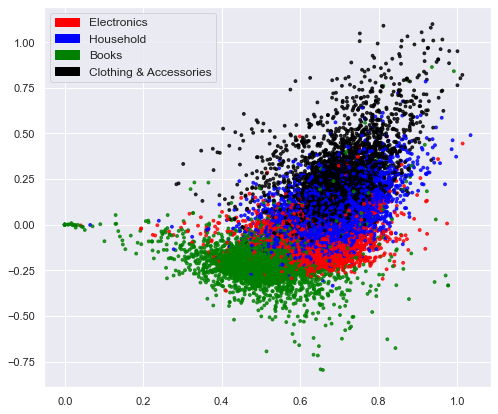

In [40]:
# Word2Vec embedding
X_train_embed = get_word2vec_embeddings(word2vec, data_train['tokens'])
X_val_embed = get_word2vec_embeddings(word2vec, data_val['tokens'])
X_test_embed = get_word2vec_embeddings(word2vec, data_test['tokens'])

fig = plt.figure(figsize = (8, 7))
plot_embedding(X_train_embed, y_train)
plt.show()

In [41]:
# Converting to Compressed Sparse Row matrix
X_train_w2v = scipy.sparse.csr_matrix(X_train_embed)
X_val_w2v = scipy.sparse.csr_matrix(X_val_embed)
X_test_w2v = scipy.sparse.csr_matrix(X_test_embed)

### Word2Vec Baseline Modeling

In [42]:
# Summary of baseline models
score(X_train_w2v, y_train, X_val_w2v, y_val, names = names, models = models)

,Classifier,Training accuracy,Validation accuracy
6,XGBoost,0.999955,0.943525
3,Linear SVM,0.937233,0.934173
0,Logistic Regression,0.931613,0.929856
5,SGD Classifier,0.931208,0.929496
4,Random Forest,0.999955,0.928417
1,KNN Classifier,0.913268,0.912590
7,AdaBoost,0.864485,0.862590
2,Decision Tree,0.999955,0.812590


In [43]:
# Hyperparameter tuning for XGBoost
xgb = XGBClassifier()
params_xgb = {
    'learning_rate': [0.03, 0.3],
    'min_child_weight': [0, 10],
    'n_estimators': [200],
    'reg_lambda': [1, 2],
    'seed': [40]
}

best_model_xgb, best_params_xgb, best_score_xgb, count = xgb, ParameterGrid(params_xgb)[0], 0, 0
for g in ParameterGrid(params_xgb):
    time_start = time.time()
    count += 1
    print(f"Gridpoint #{count}: {g}")
    xgb.set_params(**g)
    xgb.fit(X_train_w2v, y_train)
    y_train_pred, y_val_pred = xgb.predict(X_train_w2v), xgb.predict(X_val_w2v)
    score_train, score_val = accuracy_score(y_train, y_train_pred), accuracy_score(y_val, y_val_pred)
    time_stop = time.time()
    m, s = int(time_stop - time_start) // 60, int(time_stop - time_start) % 60
    print(f"Training accuracy: {score_train}, Validation accuracy: {score_val}, Runtime: {m}m{s}s")
    print(" ")
    if score_val > best_score_xgb:
        best_params_xgb, best_score_xgb = g, score_val

best_model_w2v, best_params_w2v, best_score_w2v = XGBClassifier(), best_params_xgb, best_score_xgb
best_model_w2v.set_params(**best_params_w2v)
print(f"Best model: {best_model_w2v}")
print(" ")
print(f"Best parameters: {best_params_w2v}")
print(f"Best validation accuracy: {best_score_w2v}")

Gridpoint #1: {'learning_rate': 0.03, 'min_child_weight': 0, 'n_estimators': 200, 'reg_lambda': 1, 'seed': 40}
Training accuracy: 0.9729328717233937, Validation accuracy: 0.9316546762589928, Runtime: 1m6s
 
Gridpoint #2: {'learning_rate': 0.03, 'min_child_weight': 0, 'n_estimators': 200, 'reg_lambda': 2, 'seed': 40}
Training accuracy: 0.9718537835528978, Validation accuracy: 0.9320143884892086, Runtime: 1m4s
 
Gridpoint #3: {'learning_rate': 0.03, 'min_child_weight': 10, 'n_estimators': 200, 'reg_lambda': 1, 'seed': 40}
Training accuracy: 0.9689762150982419, Validation accuracy: 0.9309352517985612, Runtime: 0m59s
 
Gridpoint #4: {'learning_rate': 0.03, 'min_child_weight': 10, 'n_estimators': 200, 'reg_lambda': 2, 'seed': 40}
Training accuracy: 0.96794208893485, Validation accuracy: 0.9323741007194245, Runtime: 1m0s
 
Gridpoint #5: {'learning_rate': 0.3, 'min_child_weight': 0, 'n_estimators': 200, 'reg_lambda': 1, 'seed': 40}
Training accuracy: 0.999955037992896, Validation accuracy: 0.

# Final Prediction and Evaluation

We employ the model with the highest validation accuracy to predict the labels of the test observations and report the resulting test accuracy and confusion matrix.

In [44]:
# Function to compute and print confusion matrix
def conf_mat(y_test, y_test_pred, figsize = (10, 8), font_scale = 1.2, annot_kws_size = 16):
    class_names = [0, 1, 2, 3] # ['Electronics', 'Household', 'Books', 'Clothing & Accessories']
    tick_marks_y = [0.5, 1.5, 2.5, 3.5]
    tick_marks_x = [0.5, 1.5, 2.5, 3.5]
    confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
    confusion_matrix_df = pd.DataFrame(confusion_matrix, range(4), range(4))
    plt.figure(figsize = figsize)
    sns.set(font_scale = font_scale) # label size
    plt.title("Confusion Matrix")
    sns.heatmap(confusion_matrix_df, annot = True, annot_kws = {"size": annot_kws_size}, fmt = 'd') # font size
    plt.yticks(tick_marks_y, class_names, rotation = 'vertical')
    plt.xticks(tick_marks_x, class_names, rotation = 'horizontal')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.show()

In [45]:
# Best model
if best_score_tfidf >= best_score_w2v:
    best_model, X_train_vec, X_test_vec = best_model_tfidf, X_train_tfidf, X_test_tfidf
else:
    best_model, X_train_vec, X_test_vec = best_model_w2v, X_train_w2v, X_test_w2v

In [46]:
print(best_model)

SVC(C=1, kernel='linear')


Test accuracy    0.950378
 


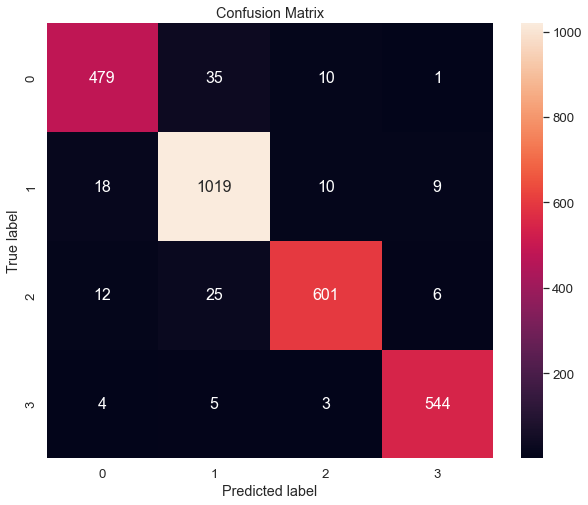

In [47]:
# Prediction and evaluation on test set
best_model.fit(X_train_vec, y_train)
y_test_pred = best_model.predict(X_test_vec)
score_test = accuracy_score(y_test, y_test_pred)
print(pd.Series({"Test accuracy": score_test}).to_string())
print(" ")
conf_mat(y_test, y_test_pred, figsize = (10, 8), font_scale = 1.2, annot_kws_size = 16) # Confusion matrix

# Transformers Step - BERT(from Google)
Implementing [BERT](https://github.com/google-research/bert) using the TensorFlow hub was tedious since we had to perform every step from scratch. First, we build our tokenizer, then design a function to process our data, and then develop our model for training.

## Implementation of BERT using hugging face transformers library

[**Hugging face <img src="https://huggingface.co/front/assets/huggingface_logo-noborder.svg" alt="Hugging Face Logo" width="25">**](https://huggingface.co/) is an NLP-focused startup that provides a wide variety of solutions in NLP for TensorFlow and PyTorch. The Transformers library contains more than 30 pre-trained models and 100 languages, along with 8 major architectures for **Natural Language Understanding** (NLU) and **Natural Language Generation** (NLG):

- [BERT](https://github.com/google-research/bert) (from Google);
- [GPT-2](https://github.com/openai/gpt-2) (from OpenAI);
- [GPT](https://github.com/openai/finetune-transformer-lm) (from OpenAI);
- [Transformer-XL](https://github.com/kimiyoung/transformer-xl) (from Google/CMU);
- [XLNet](https://github.com/zihangdai/xlnet/) (from Google/CMU);
- [RoBERTa](https://github.com/facebookresearch/fairseq/tree/main/examples/roberta) (from Facebook);
- [XLM](https://github.com/facebookresearch/XLM/) (from Facebook);
- [DistilBERT](https://huggingface.co/docs/transformers/model_doc/distilbert) (from HuggingFace).

The hugging face Transformers library required TensorFlow or PyTorch to load models. The hugging face transformers library gives you the benefit of using pre-trained language models without requiring a vast and costly computational infrastructure and with simple implementation.

- Pre-processing the raw data
- Getting BERT Pre-trained model and its tokenizer
- Training and evaluation
- Prediction Pipeline

## Pre-processing the raw data

In [48]:
#converting our integer coded label column into categorical data(matrix)
y_train1 = to_categorical(data_train_norm.label)
y_val1 = to_categorical(data_val_norm.label)
y_test1 = to_categorical(data_test_norm.label)

## Loading Model and Tokenizer from the transformers package

We need a **tokenizer** to convert the description of products word into tokens.

The **classAutoTokenizer** contains various types of tokenizers.

**TFBertModel** pre-trained Bert model for TensorFlow.

Here we are loading the bert-base-cased model.

In [49]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
bert = TFBertModel.from_pretrained("bert-base-cased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [50]:
# Example
tokenizer.tokenize("Hello, how are you?")

['Hello', ',', 'how', 'are', 'you', '?']

Put inputs(X_train_norm, X_val_norm, X_test_norm) in list form

In [51]:
X_train_norm_np = np.array(X_train_norm)
X_train_norm_list = X_train_norm_np.tolist()

X_val_norm_np = np.array(X_val_norm)
X_val_norm_list = X_val_norm_np.tolist()

X_test_norm_np = np.array(X_test_norm)
X_test_norm_list = X_test_norm_np.tolist()


## Input Data Modeling
Before training, we need to convert the input textual data into **BERT’s** input data format using a tokenizer.

Since we have loaded `bert-base-cased`, so tokenizer will also be `Bert-base-cased`.

we want the maximum length of each sentence to be 70. If a sentence is
bigger than this, it will be trimmed if a sentence is smaller than
70 then it will be padded.

In [52]:
# Tokenize the input (takes some time)
# here tokenizer using from bert-base-cased
x_train1 = tokenizer(
    text=X_train_norm_list,
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


In [53]:
x_val1 = tokenizer(
    text=X_val_norm_list,
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [54]:
x_test1 = tokenizer(
    text=X_test_norm_list,
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

Hereafter data modelling, the tokenizer will return a dictionary of (x_train1, x_val1, x_test1) containing `Input_ids`, `attention_mask` as key for their respective data.

In [55]:
input_ids = x_train1["input_ids"]
attention_mask = x_train1['attention_mask']

In [56]:
val_input_ids = x_val1["input_ids"]
val_attention_mask = x_val1['attention_mask']

In [57]:
x_test1['input_ids']

<tf.Tensor: shape=(2781, 70), dtype=int32, numpy=
array([[  101,  5442,  3208, ...,     0,     0,     0],
       [  101,   189,  1183, ...,     0,     0,     0],
       [  101,  1535,  7825, ...,     0,     0,     0],
       ...,
       [  101,  1260, 16848, ...,     0,     0,     0],
       [  101, 10473,  7168, ...,     0,     0,     0],
       [  101,   185, 26519, ...,     0,     0,     0]])>

## Model Building

**Bert layers** are designed to accept input from three arrays: *input_ids, attention_mask, and token_type_ids*.

**input_ids** represents the encoding of our input words, followed by the **attention_mask**.

The inclusion of **token_type_ids** is crucial for models, such as those used in **question-answering tasks**. However, in this specific scenario, we do not pass token_type_ids.

When working with the **Bert layer**, two input layers are required: `input_ids` and `attention_mask`. The `embeddings` derived from these inputs encapsulate the hidden states of the Bert layer. To construct **CNN layers** using these hidden states, we employ **GlobalMaxPooling1D** followed by a dense layer.

The *CNN layers*, built on top of the *BERT layer*, generate the final output. It's noteworthy that bert[0] represents the last hidden state, while bert[1] corresponds to the *pooler_output*. In the process of constructing CNN layers on the BERT layer, we utilize the hidden forms of Bert for effective feature extraction and model performance.

In [58]:
max_len = 70
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert(input_ids,attention_mask = input_mask)[0]
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(4,activation = 'sigmoid')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

## Model Compilation
Defining learning parameters and compiling the model.

In [59]:
optimizer = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    clipnorm=1.0,
    amsgrad=True
)
# Set loss and metrics
loss = CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy'), # will take care of our average accuracy for all the classes.
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = metric)

## Model Training

We have the model ready with x_train1, y_train1. Then, we can now train the model.

*Training and fine-tuning of the BERT model takes a bit longer time. so be Patience.*

In [60]:
train_history = model.fit(
    x ={'input_ids':x_train1['input_ids'],'attention_mask':x_train1['attention_mask']} ,
    y = y_train1,
    validation_data = (
    {'input_ids':x_val1['input_ids'],'attention_mask':x_val1['attention_mask']}, y_val1
    ),
    epochs=7, # sur google collab mettre epochs à 10
    batch_size=36
)

Epoch 1/7


c:\Users\gomez\anaconda3\envs\tf-new\lib\site-packages\keras\backend.py:5531: UserWarning:

"`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



618/618 [==============================] - 8750s 14s/step - loss: 0.2772 - balanced_accuracy: 0.9190 - val_loss: 0.1938 - val_balanced_accuracy: 0.9471
Epoch 2/7
618/618 [==============================] - 8314s 13s/step - loss: 0.1498 - balanced_accuracy: 0.9587 - val_loss: 0.1777 - val_balanced_accuracy: 0.9493
Epoch 3/7
618/618 [==============================] - 5338s 9s/step - loss: 0.0998 - balanced_accuracy: 0.9729 - val_loss: 0.1753 - val_balanced_accuracy: 0.9543
Epoch 4/7
618/618 [==============================] - 4597s 7s/step - loss: 0.0630 - balanced_accuracy: 0.9832 - val_loss: 0.1987 - val_balanced_accuracy: 0.9525
Epoch 5/7
618/618 [==============================] - 4649s 8s/step - loss: 0.0470 - balanced_accuracy: 0.9869 - val_loss: 0.1984 - val_balanced_accuracy: 0.9518
Epoch 6/7
618/618 [==============================] - 4628s 7s/step - loss: 0.0360 - balanced_accuracy: 0.9902 - val_loss: 0.2205 - val_balanced_accuracy: 0.9522
Epoch 7/7
618/618 [=======================

## Model Evaluation
Testing our model on the test data.

In [61]:
predicted_raw = model.predict({'input_ids':x_test1['input_ids'],'attention_mask':x_test1['attention_mask']})
predicted_raw[0]

87/87 [==============================] - 177s 2s/step


array([0.40026435, 0.9999442 , 0.23568504, 0.6404182 ], dtype=float32)

Taking the index of value having maximum probability.

In [62]:
y_predicted = np.argmax(predicted_raw, axis = 1)
y_true = data_test_norm.label

## Classification Report

In [63]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_predicted))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94       525
           1       0.95      0.97      0.96      1056
           2       0.96      0.95      0.96       644
           3       0.97      0.98      0.98       556

    accuracy                           0.96      2781
   macro avg       0.96      0.96      0.96      2781
weighted avg       0.96      0.96      0.96      2781



Test accuracy    0.957569
 


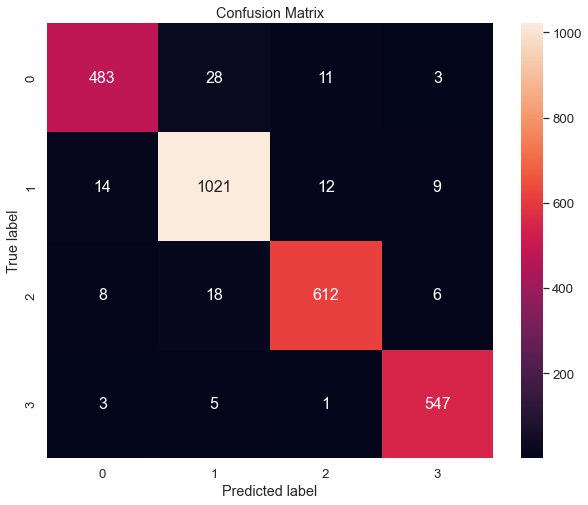

In [64]:
score_test = accuracy_score(y_true, y_predicted)
print(pd.Series({"Test accuracy": score_test}).to_string())
print(" ")
conf_mat(y_true, y_predicted, figsize = (10, 8), font_scale = 1.2, annot_kws_size = 16)

## Prediction Pipeline

During the inference phase, it is imperative to structure the input data in a manner consistent with the format used during the training process(**already done**). Subsequently, the `model.predict()` method is invoked, generating an array of probabilities associated with different classes. The next step involves identifying the index with the **highest probability** in the output array. This index is then mapped to the corresponding description product label used in the training set, thereby establishing the *predicted label* as the final output.

In [65]:
test_validation = model.predict({'input_ids':x_test1['input_ids'],'attention_mask':x_test1['attention_mask']})*100
for key , value in zip(label_dict.keys(),test_validation[0]):
    print(key,value)

87/87 [==============================] - 175s 2s/step
Electronics 40.026436
Household 99.99442
Books 23.568504
Clothing & Accessories 64.04182
